## Imports

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import ticker

import os
import sys

sys.path.append(os.path.abspath('..'))

plt.rcParams['text.usetex'] = True

from src.utils.data_utils import *
from src.utils.model_utils import *
from src.utils.plot_utils import *
from src.utils.uq_metric_utils import *
from src.utils.loss_metric_utils import *

from src.models.TurbulenceNetwork import *
from src.data_gens.TurbulenceClosureDataGenerator import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

formatter = lambda x, pos: f"{x:>6.4f}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation Plot

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


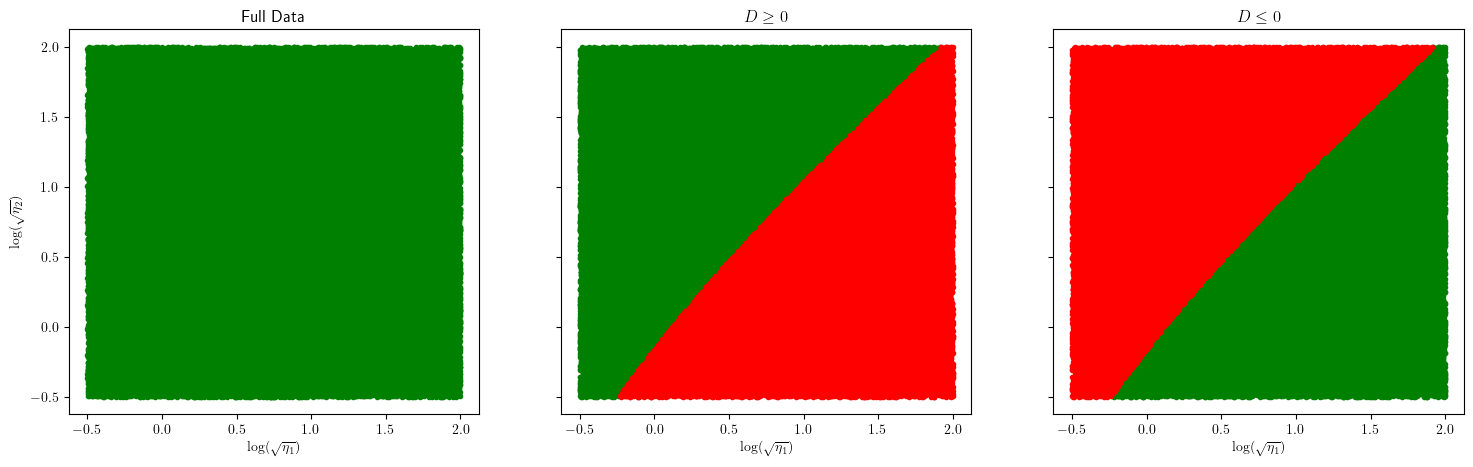

In [13]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

etas_d_gt_0, gs_d_gt_0 = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="d_condition", d_condition=">=")
etas_d_lt_0, gs_d_lt_0 = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="d_condition", d_condition="<=")
etas_full, gs_full = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="full")

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

axs[0].scatter(np.log10(np.sqrt(etas_full[:, 0])), np.log10(np.sqrt(etas_full[:, 1])), marker='.', c="g")
axs[0].set_xlabel(r"$\log(\sqrt{\eta_1})$")
axs[0].set_ylabel(r"$\log(\sqrt{\eta_2})$")
axs[0].set_title(r"Full Data")


axs[1].scatter(np.log10(np.sqrt(etas_d_gt_0[:, 0])), np.log10(np.sqrt(etas_d_gt_0[:, 1])), marker='.', c="g")
axs[1].scatter(np.log10(np.sqrt(etas_d_lt_0[:, 0])), np.log10(np.sqrt(etas_d_lt_0[:, 1])), marker='.', c="r")
axs[1].set_xlabel(r"$\log(\sqrt{\eta_1})$")
#axs[1].set_ylabel(r"$\log(\sqrt{\eta_2})$")
axs[1].set_title(r"$D \geq 0$")

axs[2].scatter(np.log10(np.sqrt(etas_d_lt_0[:, 0])), np.log10(np.sqrt(etas_d_lt_0[:, 1])), marker='.', c="g")
axs[2].scatter(np.log10(np.sqrt(etas_d_gt_0[:, 0])), np.log10(np.sqrt(etas_d_gt_0[:, 1])), marker='.', c="r")
axs[2].set_title(r"$D \leq 0$")
#axs[2].set_ylabel(r"$\log(\sqrt{\eta_2})$")
axs[2].set_xlabel(r"$\log(\sqrt{\eta_1})$")

plt.show()

## Utilities

In [14]:
def array_to_latex_table(labels, row_begin, data_arr, fmt_arr, sep=""):
    table = r"\begin{tabular}"
    table += "{" + sep + sep.join(["c" for _ in range(len(labels))]) + sep +"} \n"
    table += " & ".join(labels) + " \\\\ \n"
    for i, row in enumerate(data_arr):
        table += row_begin[i] + " & " + " & ".join([f"{x:{fmt_arr[j]}}" for j,x in enumerate(row)]) + " \\\\ \n"
    table += r"\end{tabular}"
    return table

## Loading Reference Data

In [15]:
dim = 700
log = (-.5, 2)

x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

two_gps = True
aleatoric = False
model_dir = "Aleatoric_40k/"
model_prefix = "Regular_Alea_40k"

## Loading Ensemble, MC-Dropout, and SVI results

In [16]:
ensemble_pred = np.loadtxt("../data/Ensemble/" + model_dir + model_prefix + "_Pred_Mean.csv", delimiter=",")
ensemble_std = np.loadtxt("../data/Ensemble/" + model_dir + model_prefix + "_Pred_Std.csv", delimiter=",") 

mcd_pred = np.loadtxt("../data/MCD/" + model_dir + model_prefix + "_Pred_Mean.csv", delimiter=",")
mcd_std = np.loadtxt("../data/MCD/" + model_dir + model_prefix + "_Pred_Std.csv", delimiter=",")
mcd_std[np.where(mcd_std <= 1e-8)] = mcd_std.mean()

svi_pred = np.loadtxt("../data/SVI/" + model_dir + model_prefix + "_Pred_Mean.csv", delimiter=",")
svi_std = np.loadtxt("../data/SVI/" + model_dir + model_prefix + "_Pred_Std.csv", delimiter=",")

gp1_pred = np.loadtxt("../data/GP/" + model_dir + model_prefix + "_Pred_Mean.csv", delimiter=",")
gp1_std = np.loadtxt("../data/GP/" +  model_dir + model_prefix + "_Pred_Std.csv", delimiter=",")

if aleatoric:
    ensemble_sigma = np.loadtxt("../data/Ensemble/" + model_dir + model_prefix + "_Sigmas.csv", delimiter=",")
    mcd_sigma = np.loadtxt("../data/MCD/" + model_dir + model_prefix + "_Sigmas.csv", delimiter=",")
    svi_sigma = np.loadtxt("../data/SVI/" + model_dir + model_prefix + "_Sigmas.csv", delimiter=",")
    gp1_sigma = np.loadtxt("../data/GP/" + model_dir + model_prefix + "_Sigmas.csv", delimiter=",")
    if two_gps:
        gp2_sigma = np.loadtxt("../data/GP_Pytorch/" + model_dir + model_prefix + "_Sigmas.csv", delimiter=",")


if two_gps:
    gp2_pred = np.loadtxt("../data/GP_Pytorch/" + model_dir + model_prefix + "_Pred_Mean.csv", delimiter=",")
    gp2_std = np.loadtxt("../data/GP_Pytorch/" +  model_dir + model_prefix + "_Pred_Std.csv", delimiter=",")

### Calculating Error Metrics

In [17]:
### Median Absolute Error
MDAE = MedianAELoss()

ensemble_MDAE = MDAE(torch.tensor(ensemble_pred), torch.tensor(target)).item()
mcd_MDAE = MDAE(torch.tensor(mcd_pred), torch.tensor(target)).item()
svi_MDAE = MDAE(torch.tensor(svi_pred), torch.tensor(target)).item()
gp1_MDAE = MDAE(torch.tensor(gp1_pred), torch.tensor(target)).item()
if two_gps:
    gp2_MDAE = MDAE(torch.tensor(gp2_pred), torch.tensor(target)).item()

### Mean Absolute Error
MAE = MeanAELoss()

ensemble_MAE = MAE(torch.tensor(ensemble_pred), torch.tensor(target)).item()
mcd_MAE = MAE(torch.tensor(mcd_pred), torch.tensor(target)).item()
svi_MAE = MAE(torch.tensor(svi_pred), torch.tensor(target)).item()
gp1_MAE = MAE(torch.tensor(gp1_pred), torch.tensor(target)).item()
if two_gps:
    gp2_MAE = MAE(torch.tensor(gp2_pred), torch.tensor(target)).item()

### Root Mean Squared Error
RMSE = RMSELoss()

ensemble_RMSE = RMSE(torch.tensor(ensemble_pred), torch.tensor(target)).item()
mcd_RMSE = RMSE(torch.tensor(mcd_pred), torch.tensor(target)).item()
svi_RMSE = RMSE(torch.tensor(svi_pred), torch.tensor(target)).item()
gp1_RMSE = RMSE(torch.tensor(gp1_pred), torch.tensor(target)).item()
if two_gps:
    gp2_RMSE = RMSE(torch.tensor(gp2_pred), torch.tensor(target)).item()

### Mean Absolute Relative PercZX2dXs$$xbA33wCentage Difference
MARPD = MARPDLoss()

ensemble_MARPD = MARPD(torch.tensor(ensemble_pred), torch.tensor(target)).item()
mcd_MARPD = MARPD(torch.tensor(mcd_pred), torch.tensor(target)).item()
svi_MARPD = MARPD(torch.tensor(svi_pred), torch.tensor(target)).item()
gp1_MARPD = MARPD(torch.tensor(gp1_pred), torch.tensor(target)).item()
if two_gps:
    gp2_MARPD = MARPD(torch.tensor(gp2_pred), torch.tensor(target)).item()

### R squared
R2 = R2Loss()

ensemble_R2 = R2(torch.tensor(ensemble_pred), torch.tensor(target)).item()
mcd_R2 = R2(torch.tensor(mcd_pred), torch.tensor(target)).item()
svi_R2 = R2(torch.tensor(svi_pred), torch.tensor(target)).item()
gp1_R2 = R2(torch.tensor(gp1_pred), torch.tensor(target)).item()
if two_gps:
    gp2_R2 = R2(torch.tensor(gp2_pred), torch.tensor(target)).item()

### Gather the results
error_labels = ["Method", "MAE", "RMSE"]
method_labels = ["DE", "MCD", "SVI", "EGP", "AGP"]
ensemble_errors = [ ensemble_MAE, ensemble_RMSE]
mcd_errors = [mcd_MAE, mcd_RMSE]
svi_errors = [svi_MAE, svi_RMSE]
gp1_errors = [gp1_MAE, gp1_RMSE]
if two_gps:
    gp2_errors = [gp2_MAE, gp2_RMSE]


### Calculating Uncertainty Metrics

In [18]:
### Calibration Curve
num_bins = 100
ensemble_p_i, ensemble_p_i_hat = calibration_curve(target, ensemble_pred, ensemble_std, num_bins=num_bins)
mcd_p_i, mcd_p_i_hat = calibration_curve(target, mcd_pred, mcd_std, num_bins=num_bins)
svi_p_i, svi_p_i_hat = calibration_curve(target, svi_pred, svi_std, num_bins=num_bins)
gp1_p_i, gp1_p_i_hat = calibration_curve(target, gp1_pred, gp1_std, num_bins=num_bins)
if two_gps:
    gp2_p_i, gp2_p_i_hat = calibration_curve(target, gp2_pred, gp2_std, num_bins=num_bins)

ensemble_pi_2, ensemble_pi_hat_2 = calibration_curve2(target, ensemble_pred, ensemble_std, num_bins=num_bins)
mcdf_pi_2, mcdf_pi_hat_2 = calibration_curve2(target, mcd_pred, mcd_std, num_bins=num_bins)
svi_pi_2, svi_pi_hat_2 = calibration_curve2(target, svi_pred, svi_std, num_bins=num_bins)
gp1_pi_2, gp1_pi_hat_2 = calibration_curve2(target, gp1_pred, gp1_std**2, num_bins=num_bins)


### Miscalibration Error
ensemble_miscal_area = miscalibration_area(ensemble_p_i, ensemble_p_i_hat, num_bins=num_bins)
mcd_miscal_area = miscalibration_area(mcd_p_i, mcd_p_i_hat, num_bins=num_bins)
svi_miscal_area = miscalibration_area(svi_p_i, svi_p_i_hat, num_bins=num_bins)
gp1_miscal_area = miscalibration_area(gp1_p_i, gp1_p_i_hat, num_bins=num_bins)
if two_gps:
    gp2_miscal_area = miscalibration_area(gp2_p_i, gp2_p_i_hat, num_bins=num_bins)

### Calibration Error
ensemble_calib_error = calibration_error(ensemble_p_i, ensemble_p_i_hat)
mcd_calib_error = calibration_error(mcd_p_i, mcd_p_i_hat)
svi_calib_error = calibration_error(svi_p_i, svi_p_i_hat)
gp1_calib_error = calibration_error(gp1_p_i, gp1_p_i_hat)
if two_gps:
    gp2_calib_error = calibration_error(gp2_p_i, gp2_p_i_hat)

### Sharpness
ensemble_sharpness = sharpness_score(ensemble_std, axis_mean=0)
mcd_sharpness = sharpness_score(mcd_std, axis_mean=0)
svi_sharpness = sharpness_score(svi_std, axis_mean=0)
gp1_sharpness = sharpness_score(gp1_std, axis_mean=0)
if two_gps:
    gp2_sharpness = sharpness_score(gp2_std, axis_mean=0)

### Coefficient of Variation
ensemble_C_v = coefficient_of_variation(ensemble_std, axis_mean=0)
mcd_C_v = coefficient_of_variation(mcd_std, axis_mean=0)
svi_C_v = coefficient_of_variation(svi_std, axis_mean=0)
gp1_C_v = coefficient_of_variation(gp1_std, axis_mean=0)
if two_gps:
    gp2_C_v = coefficient_of_variation(gp2_std, axis_mean=0)

### Negative Log Likelihood
ensemble_cov = np.einsum('ji, ik->jik', ensemble_std**2, np.eye(3)) + np.expand_dims(np.eye(3) * 1e-8, 0)
ensemble_nll = negative_log_likelihood(target, ensemble_pred, ensemble_cov)

mcd_cov = np.einsum('ji, ik->jik', mcd_std**2, np.eye(3)) + np.expand_dims(np.eye(3) * 1e-8, 0)
mcd_nll = negative_log_likelihood(target, mcd_pred, mcd_cov)

svi_cov = np.einsum('ji, ik->jik', svi_std**2, np.eye(3)) + np.expand_dims(np.eye(3) * 1e-8, 0)
svi_nll = negative_log_likelihood(target, svi_pred, svi_cov)

gp1_cov = np.einsum('ji, ik->jik', gp1_std**2, np.eye(3)) + np.expand_dims(np.eye(3) * 1e-8, 0)
gp1_nll = negative_log_likelihood(target, gp1_pred, gp1_cov)

if two_gps:
    gp2_cov = np.einsum('ji, ik->jik', gp2_std**2, np.eye(3)) + np.expand_dims(np.eye(3) * 1e-8, 0)
    gp2_nll = negative_log_likelihood(target, gp2_pred, gp2_cov)

### Gather the results

# calibration_labels = ["MisCal", "Sha", r"$C_v$", r"NLL"]
calibration_labels = ["MisCal"]
ensemble_calibrations = [ensemble_miscal_area, ensemble_sharpness, ensemble_C_v, ensemble_nll] if not aleatoric else [ensemble_miscal_area]
mcd_calibrations = [mcd_miscal_area, mcd_sharpness, mcd_C_v, mcd_nll] if not aleatoric else [mcd_miscal_area]
svi_calibrations = [svi_miscal_area, svi_sharpness, svi_C_v, svi_nll] if not aleatoric else [svi_miscal_area]
gp1_calibrations = [gp1_miscal_area, gp1_sharpness, gp1_C_v, gp1_nll] if not aleatoric else [gp1_miscal_area]
if two_gps:
    gp2_calibrations = [gp2_miscal_area, gp2_sharpness, gp2_C_v, gp2_nll] if not aleatoric else [gp2_miscal_area]

## Uncertainties


In [19]:
# Total Uncertainty
ensemble_tot_std = ensemble_std.mean()
mcd_tot_std = mcd_std.mean()
svi_tot_std = svi_std.mean()
gp1_tot_std = gp1_std.mean()
if two_gps:
    gp2_tot_std = gp2_std.mean()

# Aleatoric Uncertainty
if aleatoric:
    ensemble_alea_std = ensemble_sigma.mean()
    mcd_alea_std = mcd_sigma.mean()
    svi_alea_std = svi_sigma.mean()
    gp1_alea_std = gp1_sigma.mean()

    ensemble_epi_std = np.sqrt(ensemble_tot_std**2 - ensemble_alea_std**2)
    mcd_epi_std = np.sqrt(mcd_tot_std**2 - mcd_alea_std**2)
    svi_epi_std = np.sqrt(svi_tot_std**2 - svi_alea_std**2)
    gp1_epi_std = np.sqrt(gp1_tot_std**2 - gp1_alea_std**2)

    if two_gps:
        gp2_alea_std = gp2_sigma.mean()
        gp2_epi_std = np.sqrt(gp2_tot_std**2 - gp2_alea_std**2)

ensemble_uq = [ensemble_epi_std, ensemble_alea_std, ensemble_tot_std ] if aleatoric else [ensemble_tot_std]
mcd_uq = [mcd_epi_std, mcd_alea_std, mcd_tot_std] if aleatoric else [mcd_tot_std]
svi_uq = [svi_epi_std, svi_alea_std, svi_tot_std] if aleatoric else [svi_tot_std]
gp1_uq = [gp1_epi_std, gp1_alea_std, gp1_tot_std] if aleatoric else [gp1_tot_std]
if two_gps:
    gp2_uq = [gp2_epi_std, gp2_alea_std, gp2_tot_std] if aleatoric else [gp2_tot_std]

uq_labels = ["MEU", "MAU", "MTU"] if aleatoric else ["MEU"]

## Overall Latex Table

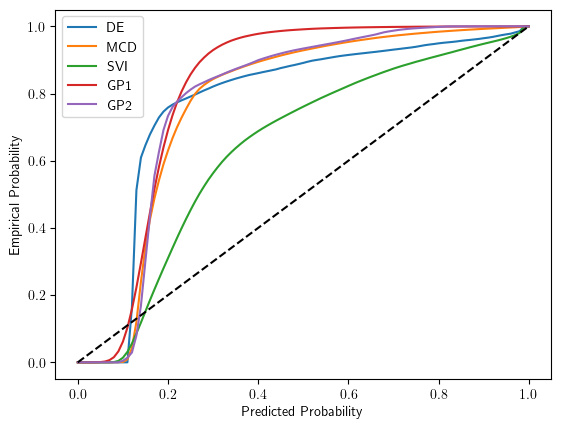

In [20]:
plt.plot(ensemble_p_i, ensemble_p_i_hat, label="DE")
plt.plot(mcd_p_i, mcd_p_i_hat, label="MCD")
plt.plot(svi_p_i, svi_p_i_hat, label="SVI")
plt.plot(gp1_p_i, gp1_p_i_hat, label="GP1")
plt.plot(gp2_p_i, gp2_p_i_hat, label="GP2")

plt.plot([0, 1], [0, 1], linestyle="--", color="black")

plt.ylabel("Empirical Probability")
plt.xlabel("Predicted Probability")

plt.legend()
plt.show()

#plt.plot(ensemble_pi_2, ensemble_pi_hat_2, label="DE")
#plt.plot(mcdf_pi_2, mcdf_pi_hat_2, label="MCD")
#plt.plot(svi_pi_2, svi_pi_hat_2, label="SVI")
#plt.plot(gp1_pi_2, gp1_pi_hat_2, label="GP1")
#
#plt.plot([0, 1], [0, 1], linestyle="--", color="black")
#
#plt.legend()
#plt.show()

In [21]:
perf_arr = [ensemble_errors+ensemble_calibrations+ensemble_uq, 
            mcd_errors+mcd_calibrations+mcd_uq, 
            svi_errors+svi_calibrations+svi_uq, 
            gp1_errors+gp1_calibrations+gp1_uq]
if two_gps:
    perf_arr.append(gp2_errors+gp2_calibrations+gp2_uq)

if aleatoric:
    fmt_arr = [".3e"]*6
else:
    fmt_arr = [".3e"] + [".3e"] + [".3f"] + [".3e"] + [".3f"] + [".3e"] + [".3e"] + [".3e"] + [".3e"] + [".3e"] + [".3e"]

print(array_to_latex_table(
    error_labels+calibration_labels+uq_labels,
    method_labels, 
    perf_arr,
    fmt_arr
    ))

\begin{tabular}{ccccc} 
Method & MAE & RMSE & MisCal & MEU \\ 
DE & 4.660e-04 & 1.142e-03 & 0.286 & 7.481e-06 & 0.075 & -7.709e+06 & 1.861e-03 \\ 
MCD & 6.749e-04 & 1.535e-03 & 0.287 & 1.213e-05 & 0.880 & -7.601e+06 & 2.281e-03 \\ 
SVI & 9.287e-04 & 1.437e-03 & 0.154 & 7.273e-06 & 0.092 & -7.627e+06 & 1.710e-03 \\ 
EGP & 5.119e-05 & 6.972e-05 & 0.324 & 1.967e-07 & 0.358 & -1.037e+07 & 3.285e-04 \\ 
AGP & 9.932e-04 & 1.678e-03 & 0.299 & 4.911e-05 & 0.204 & -6.341e+06 & 5.168e-03 \\ 
\end{tabular}


## Plotting Abs Difference

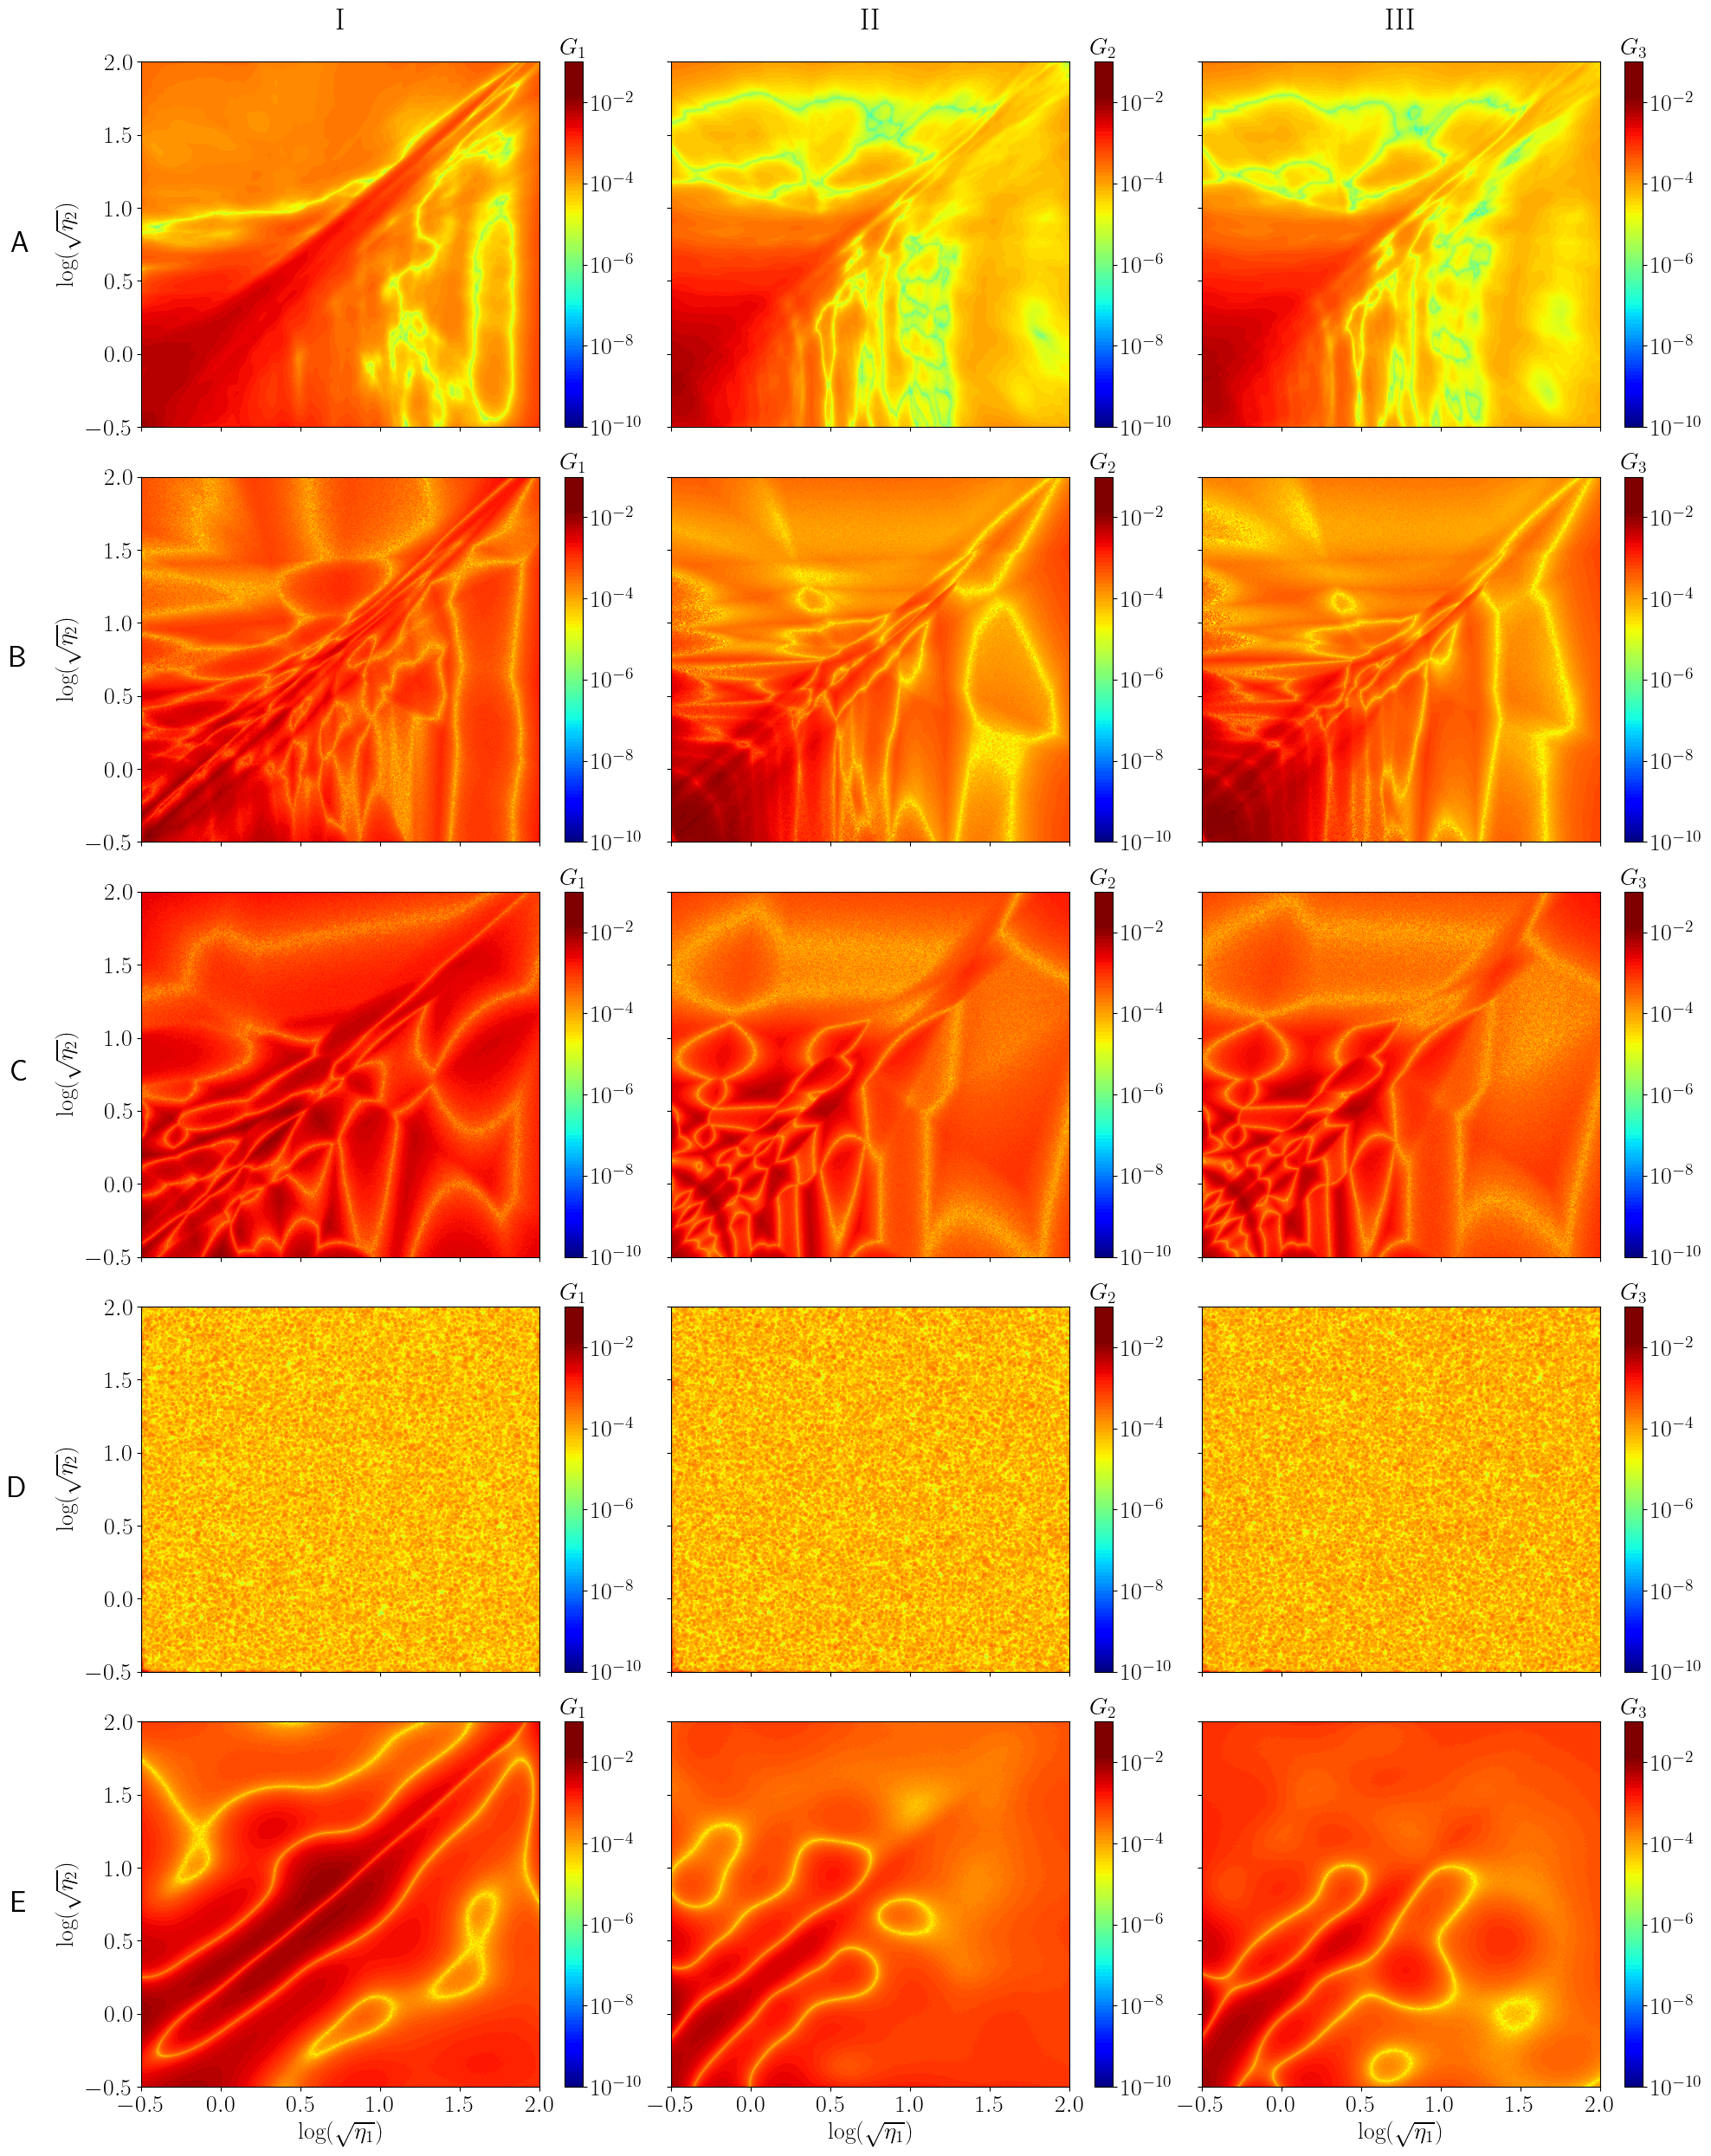

In [22]:
ensemble_error = np.abs(ensemble_pred - target)
mcd_error = np.abs(mcd_pred - target)
svi_error = np.abs(svi_pred - target)
gp1_error = np.abs(gp1_pred - target)

if two_gps:
    gp2_error = np.abs(gp2_pred - target)

ensemble_error = ensemble_error.T.reshape(3, dim, dim)
mcd_error = mcd_error.T.reshape(3, dim, dim)
svi_error = svi_error.T.reshape(3, dim, dim)
gp1_error = gp1_error.T.reshape(3, dim, dim)
if two_gps:
    gp2_error = gp2_error.T.reshape(3, dim, dim)


row_titles = ["A", "B", "C", "D", "E"]
col_titles = [r"$\mathrm{I}$", r"$\mathrm{II}$", r"$\mathrm{III}$", r"$\mathrm{IV}$", r"$\mathrm{V}$"]
if two_gps:
    fig_size = (20, 25)
else:
    fig_size = (20, 20)

if two_gps:
    err_arr = [ensemble_error, mcd_error, svi_error, gp1_error, gp2_error]
else:
    err_arr = [ensemble_error, mcd_error, svi_error, gp1_error]

plot_grid(x_grid,
          y_grid, 
          err_arr, 
          row_titles, 
          col_titles, 
          frmt=None, 
          figsize=fig_size,
          ind_scales=False, 
          save_path="../Figures/Combined/" + model_prefix + "_Pred_Error.png",
          locator=ticker.LogLocator,
          low_bound=1e-10
        )

## Plotting STD of Ensemble, MC-Dropout, and SVI

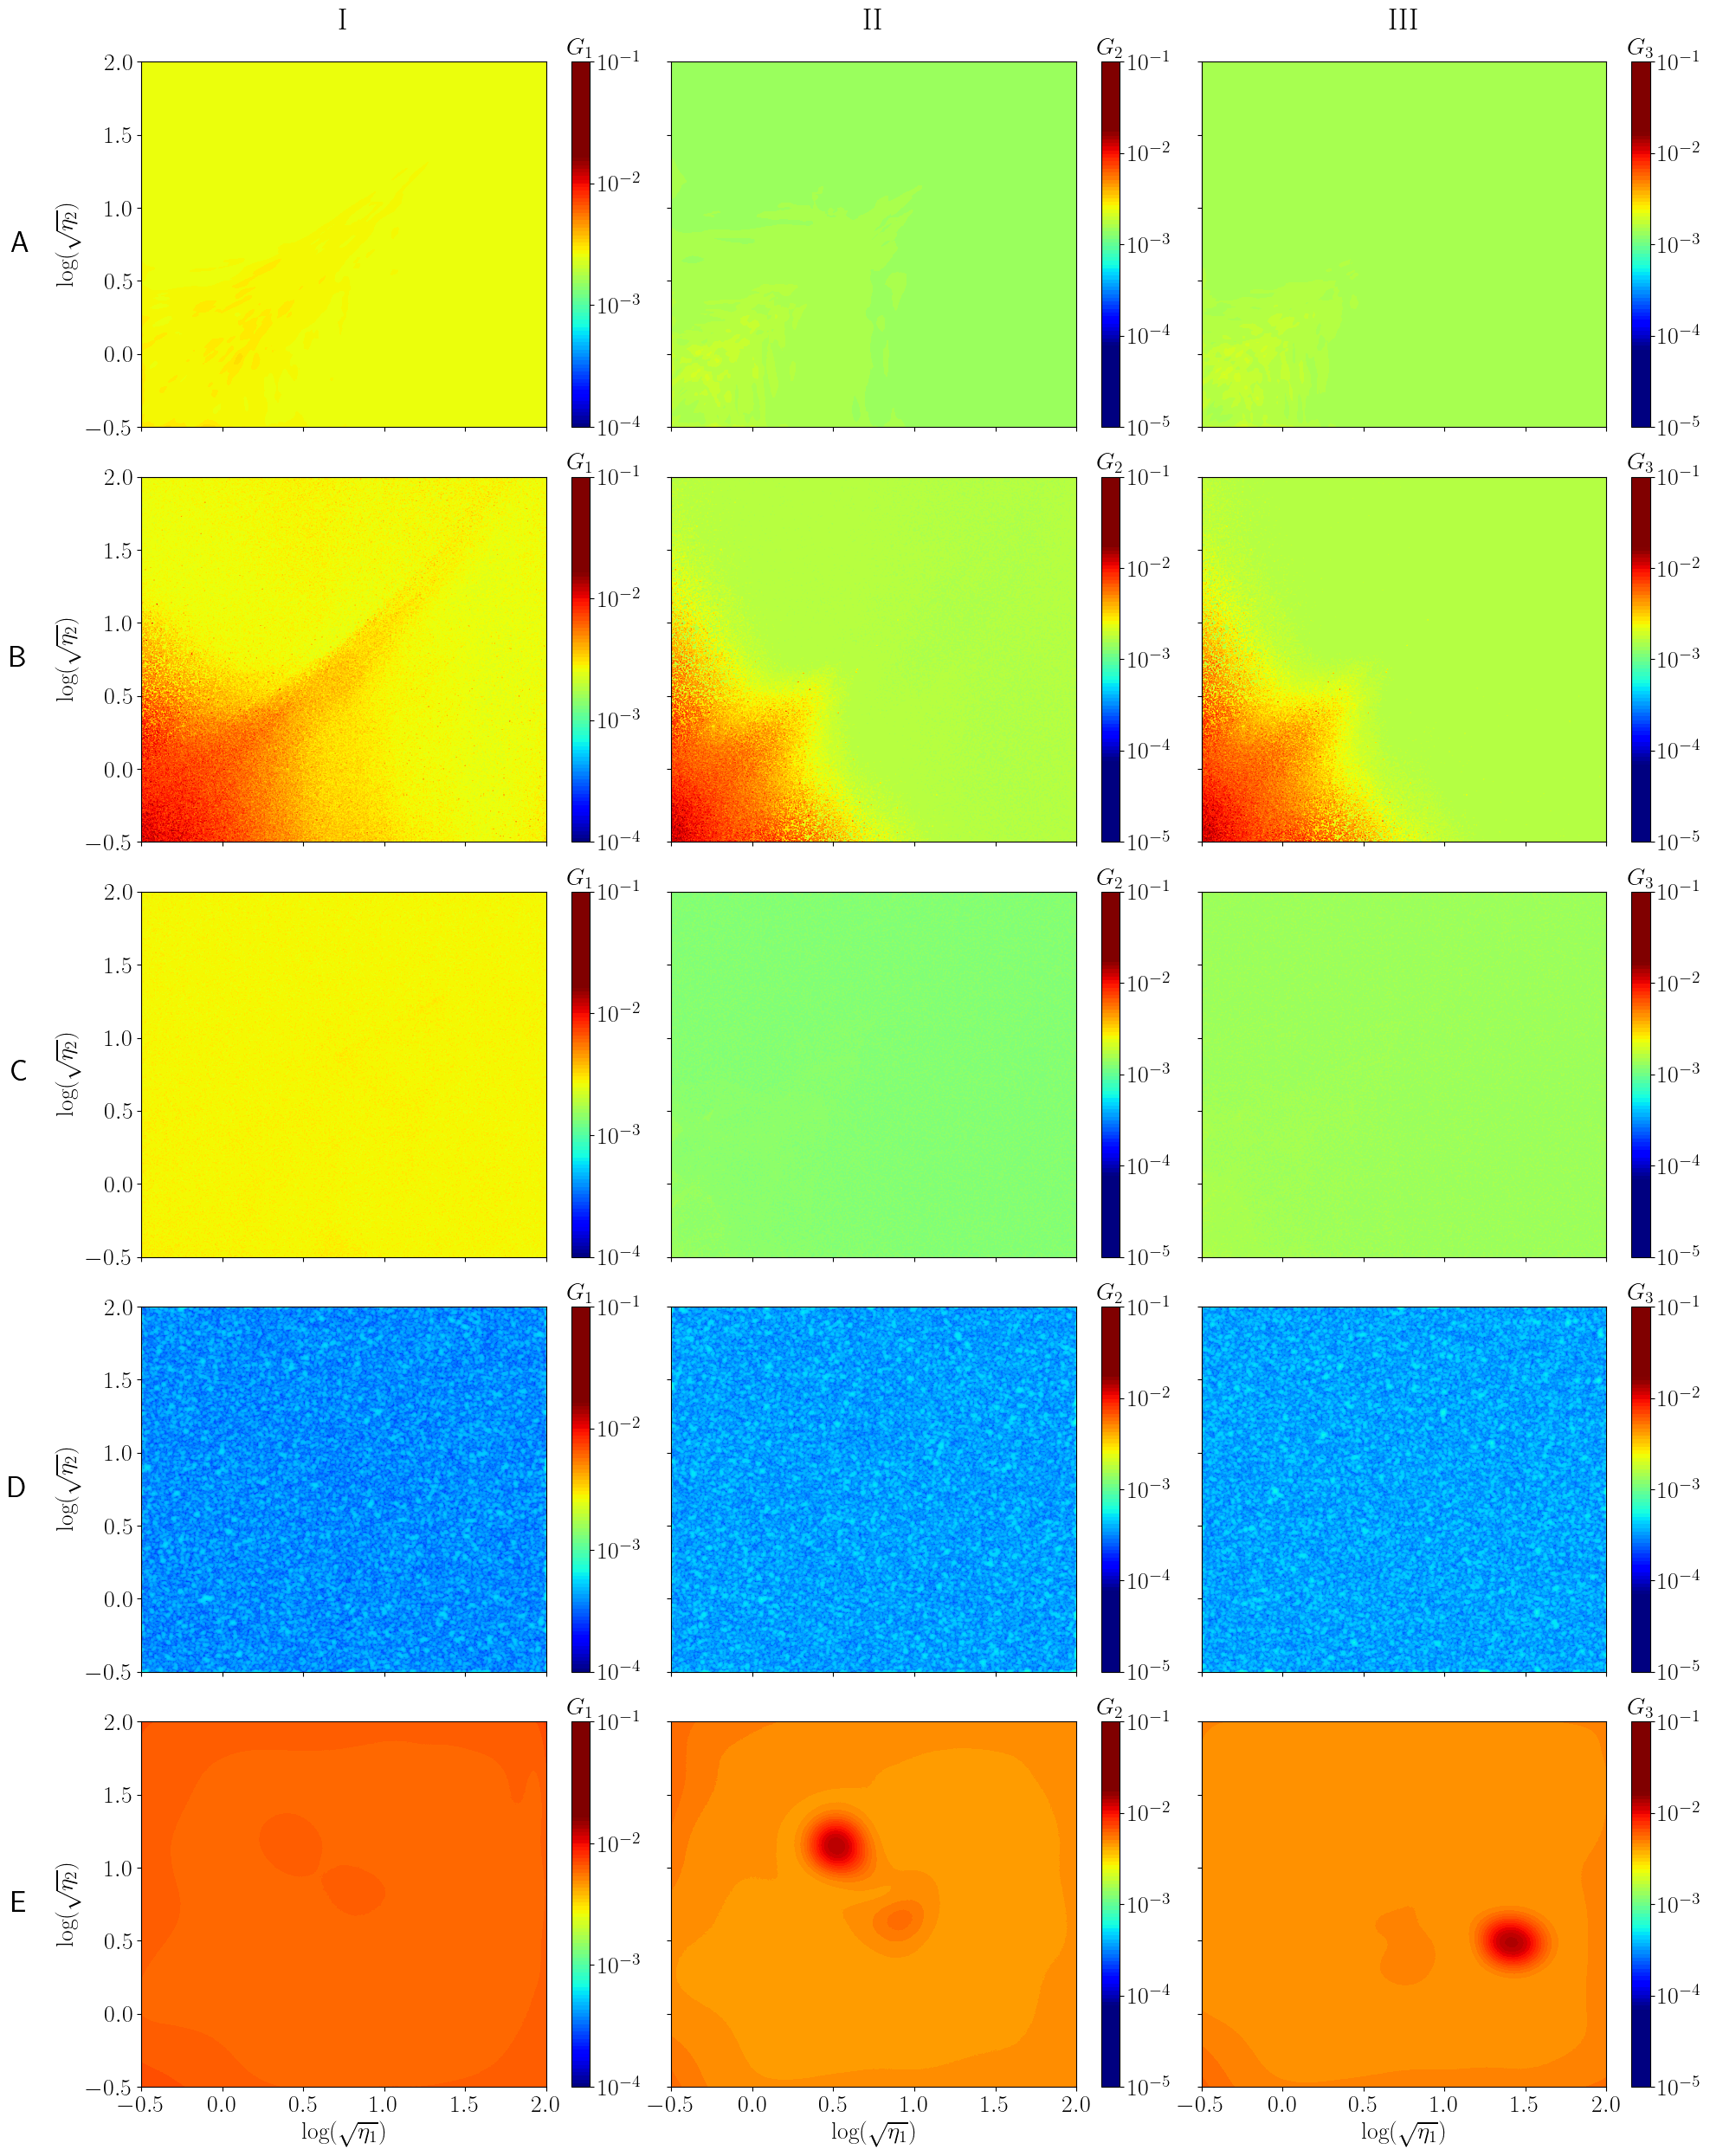

In [23]:
if two_gps:
    std_arr = [ensemble_std.T.reshape(3, dim, dim), mcd_std.T.reshape(3, dim, dim), svi_std.T.reshape(3, dim, dim), gp1_std.T.reshape(3, dim, dim), gp2_std.T.reshape(3, dim, dim)]
else:
    std_arr = [ensemble_std.T.reshape(3, dim, dim), mcd_std.T.reshape(3, dim, dim), svi_std.T.reshape(3, dim, dim), gp1_std.T.reshape(3, dim, dim)]

plot_grid(
    x_grid,
    y_grid,
    std_arr,
    row_titles,
    col_titles,
    frmt=None,
    figsize=fig_size, 
    ind_scales=False,  
    save_path="../Figures/Combined/" + model_prefix + "_Pred_STD.png",
    locator=ticker.LogLocator,
    low_bound=1e-5
)

### Number of STD's Plot

[0.037548852948027796, 0.18059104648643085, 0.8626219317308396, 0.18582712920004138]


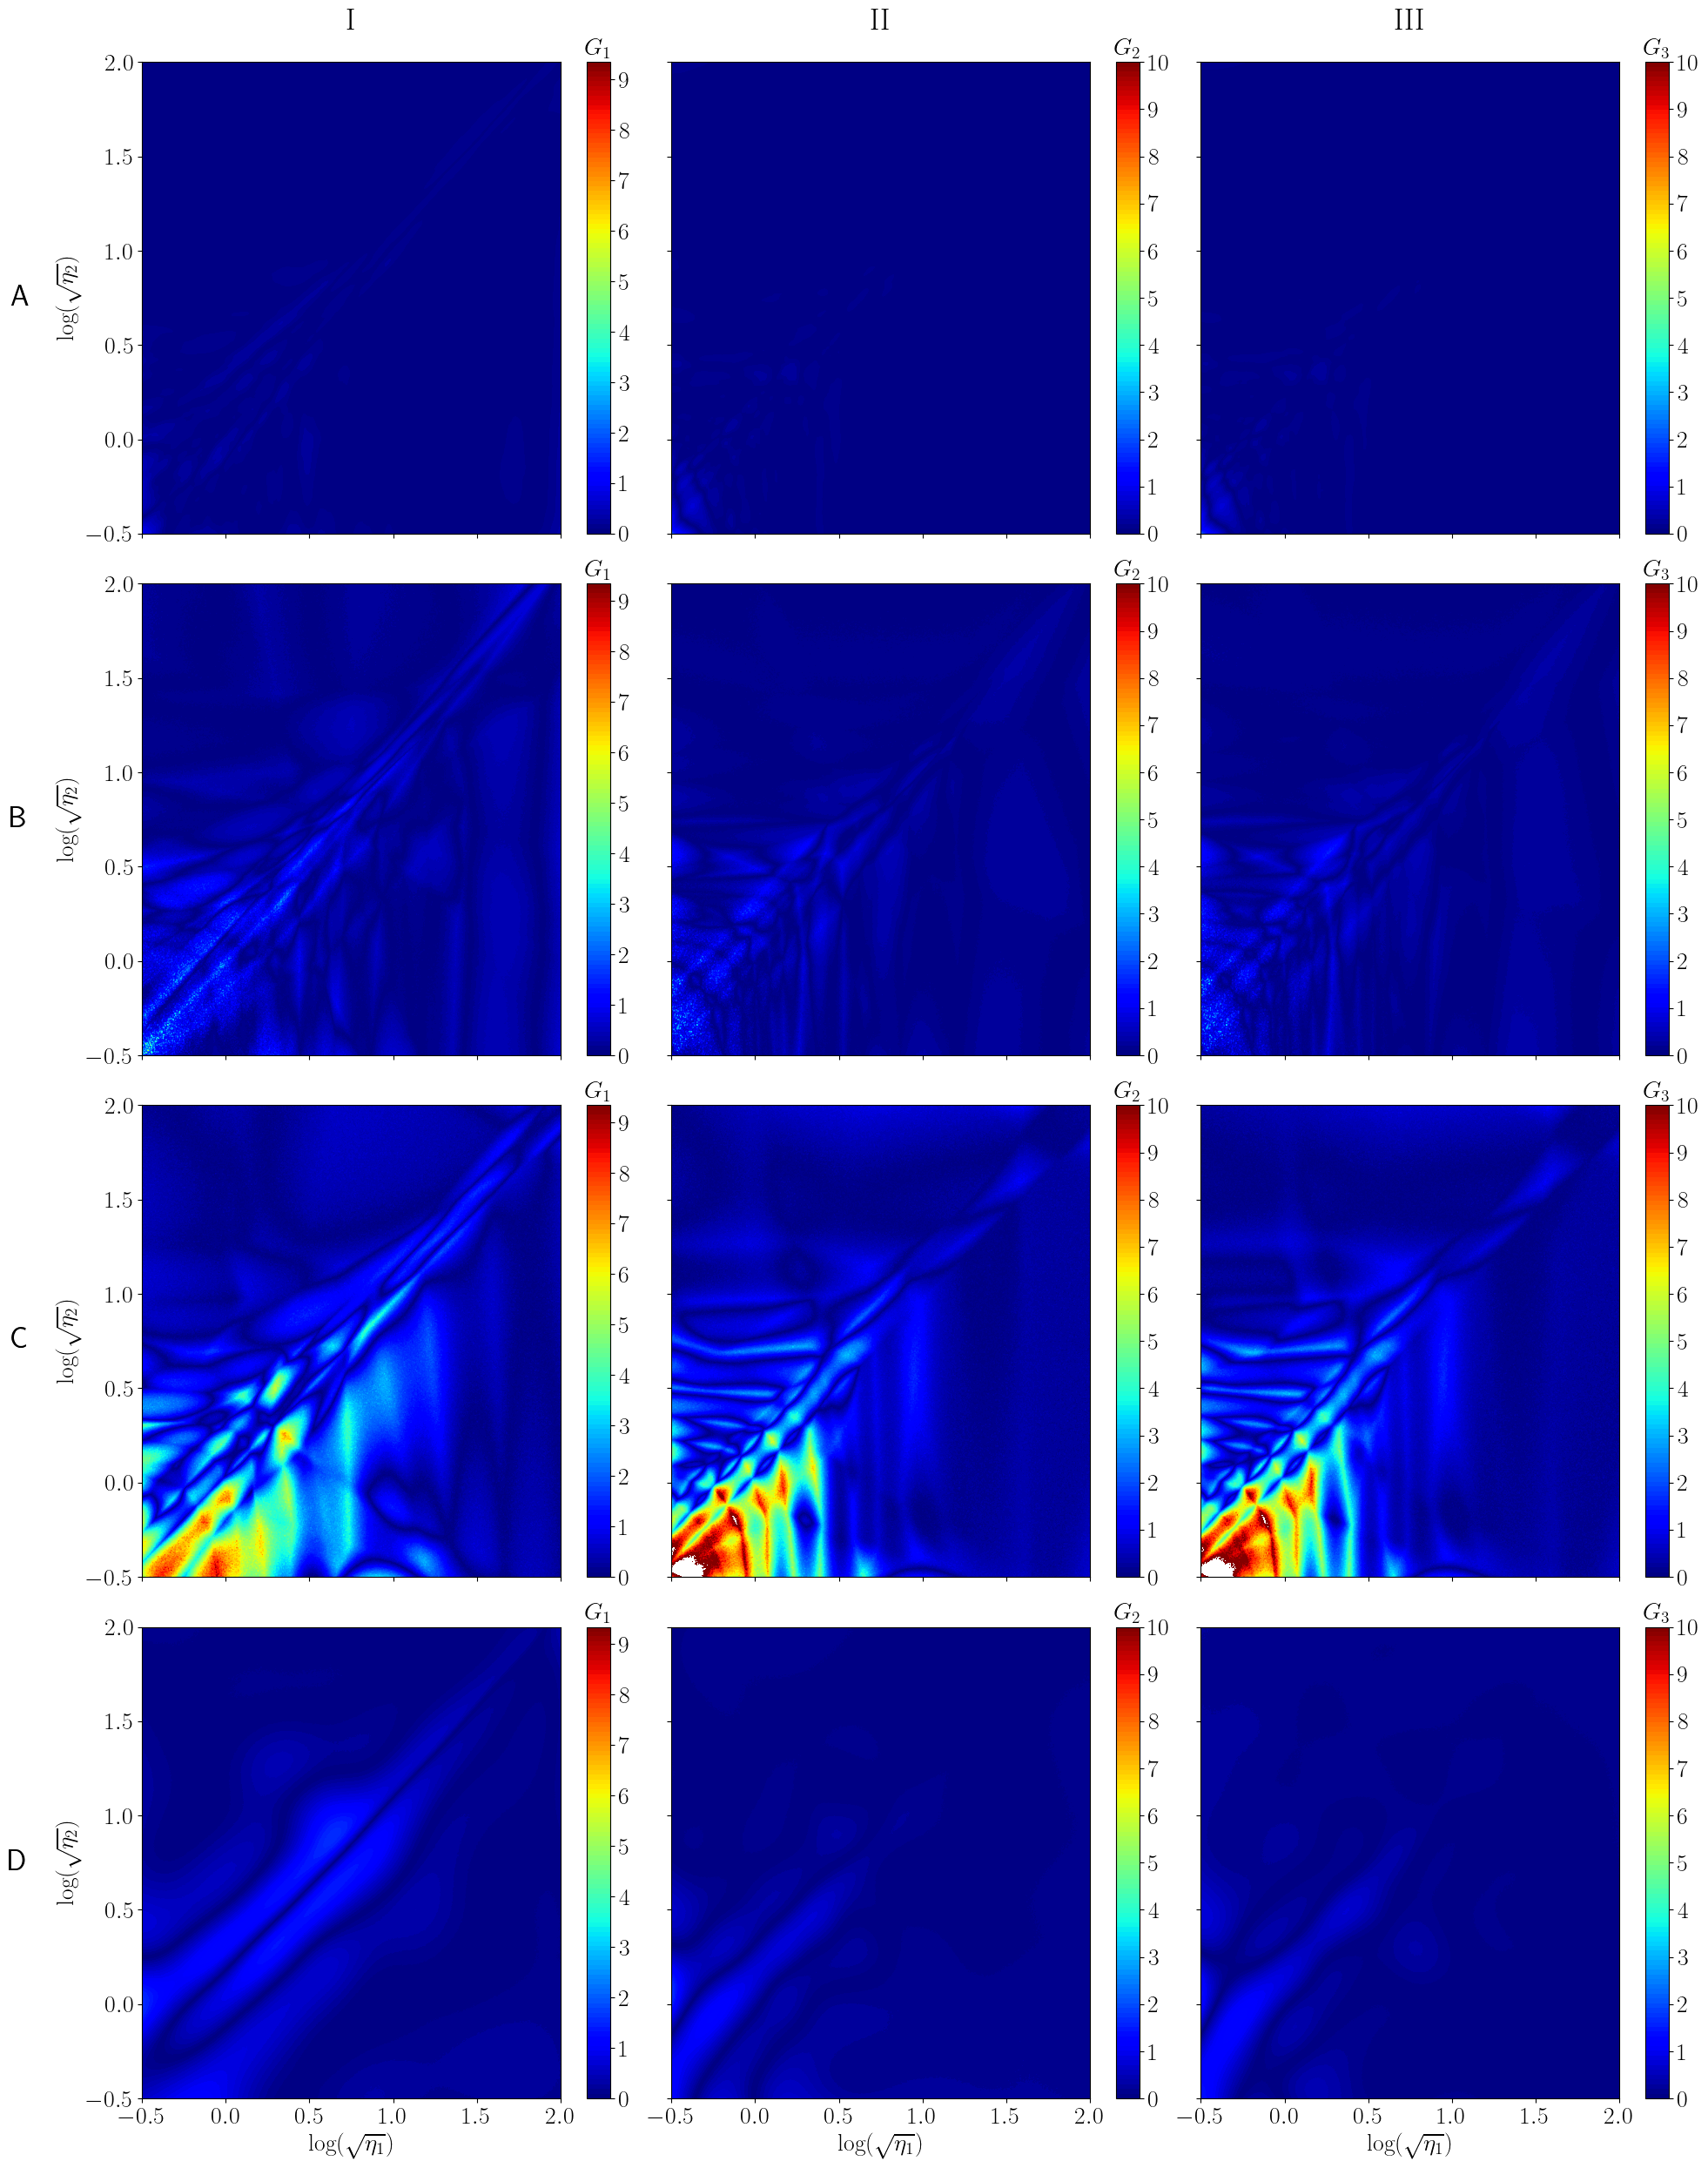

In [20]:
std_num = [pred/std for pred, std in zip(err_arr, std_arr)]
std_num.pop(3)
print([np.mean(x) for x in std_num])

plot_grid(
    x_grid,
    y_grid,
    std_num,
    row_titles,
    col_titles,
    frmt=None,
    figsize=fig_size, 
    ind_scales=False,  
    save_path="../Figures/Combined/" + model_prefix + "_Pred_STD.png",
    upper_bound=10
)
    

### Generating data to get accurate scalers

In [11]:
from sklearn.preprocessing import StandardScaler

# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 80_000, shuffle=True, gen_type="All")

#etas_vis, gs_vis = generate_log_data(SSG_gen, log, 20_000, shuffle=True, gen_type="All")

etas_vis = np.load("../data/etas.npy")
gs_vis = np.load("../data/gs.npy")

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


### Function Visualization

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = "../Model_Checkpoints/"

x_vis = torch.tensor(x_scaler.transform(etas_vis), dtype=torch.float32).to(device)
y_vis = torch.tensor(y_scaler.transform(gs_vis), dtype=torch.float32).to(device)

#y_trans = y_scaler.inverse_transform(y_vis.cpu().numpy()).reshape(1,-1)
y_trans = y_vis.cpu().numpy().reshape(1,-1)


## Gaussian Process Predictions

In [ ]:
# Exact GP
samples = []
for i in range(3):
    sample_dim = np.load("../data/GP/" + model_dir + model_prefix + f"_{i}_Samples.npy")
    samples.append(np.expand_dims(sample_dim, 2))

samples = np.concatenate(samples, axis=2)

for i, sample in enumerate(samples):
    samples[i] = y_scaler.transform(sample)

print(samples.shape)

egp_predictions = samples.reshape(samples.shape[0], -1)

print(egp_predictions.shape)

egp_err = np.abs(egp_predictions-y_trans)
print("Exact GP Error: ", np.mean(egp_err))

# Approximate GP

samples = []
for i in range(3):
    sample_dim = np.load("../data/GP/" + model_dir + model_prefix + f"_{i}_Samples.npy")
    samples.append(np.expand_dims(sample_dim, 2))

samples = np.concatenate(samples, axis=2)

#for i, sample in enumerate(samples):
#    samples[i] = y_scaler.transform(sample)


agp_predictions = samples.reshape(samples.shape[0], -1)
print(agp_predictions.shape)

agp_err = np.abs(agp_predictions - y_trans)
print("Approx GP Error: ", np.mean(agp_err))

(50, 2000, 3)
(50, 6000)
Exact GP Error:  0.003508457462577166
(50, 6000)
Approx GP Error:  0.25822183


### Ensemble Predictions

In [14]:
from skorch import NeuralNetRegressor

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        "optimizer__weight_decay": 1e-6,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 100,
        "device": device,
        "verbose": 0,
}

num_members = 40

ens_dir = "/Ensemble/Regular/"
ensemble = []

for i in range(num_members):
    net = reinitialize_model(f'Regular_Ens_{i}.pt', checkpoint_dir+ens_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    ensemble.append(net)

ens_predictions = []
for member in ensemble:
    ens_predictions.append(member.predict(x_vis).reshape(1,-1))
    #ens_predictions.append(y_scaler.inverse_transform(member.predict(x_vis)).reshape(1,-1))

ens_predictions = np.concatenate(ens_predictions, axis=0)

ens_error = np.abs(ens_predictions - y_trans)
print(f"Ensemble Error: {np.mean(ens_error)}")


Ensemble Error: 0.006489643361419439


### MC-Dropout Predictions

In [44]:
names = [
    'Regular_MCD1.pt',
    'Regular_MCD2.pt',
]

mcd_dir = "MCD/"

net_params = {
        "input_dim": 2,
        "output_dim": 3,
        "num_layers": 4,
        "h_dim": 20,
        "dropout": [0.001, 0.001, 0.001],
}

train_params = {
        "criterion": nn.MSELoss,
        "optimizer": torch.optim.Adam,
        #"optimizer__weight_decay": 1e-7,
        "lr": 0.001,
        "batch_size": 64,
        "max_epochs": 1000,
        "device": device,
        "verbose": 0,
}

T = 100

mcd_predictions = []
mcd_labels = []

for i, name in enumerate(names):
    net = reinitialize_model(name, checkpoint_dir+mcd_dir, TurbulenceNetwork, NeuralNetRegressor, net_params, train_params)
    net.module.dropout_on()
    predictions = np.zeros((T, x_vis.shape[0], 3))
    for j in range(T):
        predictions[j] = net.module(x_vis.to(device)).cpu().detach().numpy()
        #predictions[j] = y_scaler.inverse_transform(net.module(x_vis.to(device)).cpu().detach().numpy())
    mcd_predictions.append(predictions.reshape(T, -1))
    mcd_labels.append(i*np.ones(T))


mcd_predictions = np.concatenate(mcd_predictions, axis=0)
mcd_labels = np.concatenate(mcd_labels, axis=0)

error = np.abs(mcd_predictions - y_trans)

print(f"Mean error: {np.mean(error)}")

Mean error: 0.010532854922215144


### SVI Predictions

In [45]:
import pyro
from pyro.infer import Predictive

from pyro.infer.autoguide import AutoLowRankMultivariateNormal

model_params = {
    "input_dim": 2,
    "output_dim": 3,
    "h_nodes": 20,
    "num_layers": 4,
    "data_size": etas_train.shape[0],
    "layer_prior": torch.tensor([0., 10.], device=device),
    "device": device,
    "output_prior_conc_rate": torch.tensor([3.0, 1.0], device=device)
}

svi_names = [
    'Regular_SVI1',
    "Regular_SVI2"
    ]

svi_predictions = []
svi_labels = []

for i, chkpt in enumerate(svi_names):
    pyro.clear_param_store()
    model = TurbulenceNetworkBayesian(**model_params)
    model, guide = load_pyro_model(model, "../Model_Checkpoints/SVI", device, chkpt_name=chkpt)
    predictive = Predictive(model, guide=guide, num_samples=100, return_sites=("obs",))
    preds = predictive(x_vis)['obs'].detach().cpu()
    for j in range(preds.shape[0]):
        preds[j] = torch.tensor(preds[j].numpy())
        #preds[j] = torch.tensor(y_scaler.inverse_transform(preds[j].numpy()))
    preds = preds.reshape(preds.shape[0], -1)
    svi_predictions.append(preds)
    svi_labels.append(np.ones(preds.shape[0])*i)

svi_predictions = torch.cat(svi_predictions, dim=0).numpy()
svi_labels = np.concatenate(svi_labels)

error = np.abs(svi_predictions - y_trans)
print(f"ERROR: {np.mean(error)}")

ERROR: 0.019243361428380013


## PHATE

Calculating PHATE...
  Running PHATE on 541 observations and 6000 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.17 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.07 seconds.
    Calculating affinities...
    Calculated affinities in 0.03 seconds.
  Calculated graph and diffusion operator in 1.28 seconds.
  Calculating optimal t...
    Automatically selected t = 8
  Calculated optimal t in 0.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.02 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 0.29 seconds.
Calculated PHATE in 1.71 seconds.


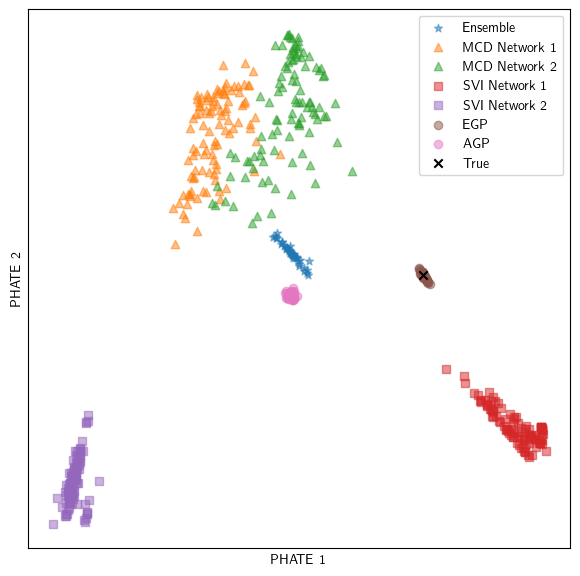

In [ ]:
from phate import PHATE

phate_input = np.concatenate([ens_predictions, mcd_predictions, svi_predictions, egp_predictions, agp_predictions, y_trans], axis=0)
phate_op = PHATE(n_components=2, n_jobs=5, random_state=42, knn=150, gamma=-0.5)

phate_output = phate_op.fit_transform(phate_input)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))

## Ensemble
ax.scatter(phate_output[:ens_predictions.shape[0], 0], phate_output[:ens_predictions.shape[0], 1], label="Ensemble", marker='*', alpha=0.5)

## MCD
for i, name in enumerate(names):
    indices = np.where(mcd_labels == i)[0] + ens_predictions.shape[0]
    plt.scatter(phate_output[indices, 0], phate_output[indices, 1], label=f"MCD Network {i+1}", marker='^', alpha=0.5)

## SVI
for i, name in enumerate(svi_names):
    indices = np.where(svi_labels == i)[0] + ens_predictions.shape[0] + mcd_predictions.shape[0]
    plt.scatter(phate_output[indices, 0], phate_output[indices, 1], label=f"SVI Network {i+1}", marker='s', alpha=0.5)

## Exact GP
egp_start = ens_predictions.shape[0] + mcd_predictions.shape[0] + svi_predictions.shape[0]
egp_end = egp_start + egp_predictions.shape[0]
plt.scatter(phate_output[egp_start:egp_end, 0], phate_output[egp_start:egp_end, 1], label="EGP", marker='o', alpha=0.5)

## Approx GP
agp_start = ens_predictions.shape[0] + mcd_predictions.shape[0] + svi_predictions.shape[0] + egp_predictions.shape[0]
plt.scatter(phate_output[agp_start:-1, 0], phate_output[agp_start:-1, 1], label="AGP", marker='o', alpha=0.5)


plt.scatter(phate_output[-1, 0], phate_output[-1, 1], label="True", c='black', marker='x')


plt.xlabel("PHATE 1")
plt.xticks([])

plt.ylabel("PHATE 2")
plt.yticks([])


plt.legend()
plt.savefig("../Figures/Combined/PHATE_Prediction.png")
plt.show()